## Исследование данных о российском кинопрокате



В текущем исследовании необходимо изучить рынок российского кинопроката и выявить текущие тренды. Уделить внимание фильмам, которые получили государственную поддержку. Ответить на вопрос, насколько такие фильмы интересны зрителю.
Будем работать с данными, опубликованными на портале открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

###  Откроем файлы с данными и объединим их в один датафрейм. 

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('chained_assignment', None)

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Скачиваем датасеты
try:
    mkrf_movies = pd.read_csv('mkrf_movies.csv', parse_dates=['show_start_date'])
    mkrf_shows = pd.read_csv('mkrf_shows.csv')
except:
    mkrf_movies = pd.read_csv('/datasets/mkrf_movies.csv', parse_dates=['show_start_date'])
    mkrf_shows = pd.read_csv('/datasets/mkrf_shows.csv')

In [4]:
#выведем информацию о датафреймах
mkrf_movies.info()
mkrf_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   puNumber               7486 non-null   object             
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   object             
 5   production_country     7484 non-null   object             
 6   director               7477 non-null   object             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

In [5]:
# Объединять таблицы будем по puNumber, но у данного признака в первой таблице не целочисленные значения.
# Посмотрим на него и приведем к целочисленному
# Посмотрим на данные
mkrf_movies['puNumber'].sort_values(ascending=False).head(5)

1797          нет
5249    231001111
1011    231001012
3992    226019110
4355    226017410
Name: puNumber, dtype: object

In [6]:
# проверим, есть ли нули.
mkrf_movies['puNumber'].fillna(0).astype(bool).sum()

7486

In [7]:
# Заменим "Нет" на ноль
mkrf_movies.loc[mkrf_movies['puNumber'] == 'нет', 'puNumber'] = 0
mkrf_movies['puNumber'] = mkrf_movies['puNumber'].astype(int)

In [8]:
# Объеденим датафреймы
data = mkrf_movies.merge(mkrf_shows, on='puNumber', how='left')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   puNumber               7486 non-null   int32              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   object             
 5   production_country     7484 non-null   object             
 6   director               7477 non-null   object             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

###### В данной части исследования был подготовлен датафрейм для дальнейшего анализа, для этого прочитали данные из различных источников. Затем объеденили их по номеру прокатного удостоверения. Внимание, номер прокатного удостоверения равный нулю, означает отсутствие оного.

### Предобработка данных

#### Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.

###### Дату начала проката перевели в дату на этапе чтения файла

In [10]:
# Посмотрим почему признак "рейтинг" не "float"
data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

In [11]:
unknown_ratings = ['99%', '28%', '97%','83%', '64%',
                  '91%', '94%', '62%', '79%', '90%',
                  '19%', '88%', '89%', '98%']

In [12]:
# доля не вбросов
len(data.loc[data['ratings'].isin(unknown_ratings)]) / len(data['ratings'])

0.0038738979428266096

In [13]:
# Заменим проценты на NAN
data.loc[data['ratings'].isin(unknown_ratings), 'ratings'] = np.nan

In [14]:
data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6', '3.8',
       '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7', '4.9',
       '3.9', '2.7', '3.3', '2.9', '3.7', '1.4', '3.1', '3.5', '3.2',
       '2.8', '1.5', '2.1', '2.5', '9.2', '3.4', '1.1', '3.6', '1.0',
       '1.3', '1.9', '1.8', '1.2', '1.7', '9.0', '8.9', '9.1'],
      dtype=object)

In [15]:
data['ratings'] = data['ratings'].astype(float)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   puNumber               7486 non-null   int32              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   object             
 5   production_country     7484 non-null   object             
 6   director               7477 non-null   object             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

###### Дату начала проката перевели в тип данных - дата на этапе чтения файла. 
###### Доля не верных значений в признаке - рейтинг составляет 0,4%.  Перевели в численный формат, предварительно убрав вбросы.

#### Изучим пропуски в датафрейме

In [17]:
data.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                    976
box_office               4328
dtype: int64

##### Студия

In [18]:
data[data['film_studio'].isna() == True]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1293,Stars in Shorts,121011114,2014-06-03 12:00:00+00:00,Художественный,NaN,"США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.30,комедия,NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN
6105,Значит любит,111013818,2018-08-10 12:00:00+00:00,Художественный,NaN,Россия,А.Краевский,Е.Щербакова,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6181,Несейка. Младшая дочь,112007018,2018-09-01 12:00:00+00:00,Документальный,NaN,Россия,В.Марин,"Д.Якунин, Ф.Абрютин, О.Филонова",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6379,Ян Антонышев,112011818,2018-11-15 12:00:00+00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6380,Ян Антонышев,112011918,2018-11-15 12:00:00+00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6399,Доживем до каникул?..,111021918,2018-11-15 12:00:00+00:00,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,41225.00
6485,До и После,112014418,2018-12-05 12:00:00+00:00,Документальный,NaN,Россия,А.Новокреповская,А.Новокреповская,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.90,"драма,криминал,детектив",NaN
6494,Калмыцкий геше Нгаванг Вангьял,113002018,2018-12-05 12:00:00+00:00,Научно-популярный,NaN,Россия,И.Долгина,И.Долгина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6497,Мой папа Чингисхан,112014918,2018-12-06 12:00:00+00:00,Документальный,NaN,Россия,А.Сайфуллина,А.Сайфуллина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### В интернете про студии, на которых сняты данные фильмы найти ничего не удалось. Скорее всего в данных фильмах не использовались студийные съемки.

##### Страна

In [19]:
data[data['production_country'].isna() == True]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00+00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.20,"детский,комедия",194527.00
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN


In [20]:
# Заполним пропуски
data.loc[data['production_country'].isna() == True, 'production_country'] = 'Россия'

#####  Возвратные, не возвратные средства поддержки

In [21]:
# Заполним нулями
data.loc[data['refundable_support'].isna() == True, 'refundable_support'] = 0
data.loc[data['nonrefundable_support'].isna() == True, 'nonrefundable_support'] = 0

###### Данные поля - численные. Принимаем, что картины без сумм, не поддерживались государством. Заменили пропуски на 0

##### Бюджет

In [22]:
# Проверим есть ли значения поддержки больше чем значения бюджета
data['budget'] = data['budget'].fillna(0)
data.loc[data['refundable_support'] > data['budget'], 'budget'] = data['refundable_support'] + data['nonrefundable_support']

In [23]:
data.loc[data['nonrefundable_support'] > data['budget'], 'budget'] = data['refundable_support'] + data['nonrefundable_support']

In [24]:
data.loc[data['refundable_support'] > data['budget']]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


In [25]:
data.loc[data['nonrefundable_support'] > data['budget']]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


###### Заменили значения бюджета суммой поддержек, если сумма поддержки превышает сумму бюджета

##### Источники финансирования

In [26]:
# Проверим есть ли не заполеные источники финансирования при не нулевой поддержке
data.query('refundable_support != 0 & financing_source.isna()')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


In [27]:
data.query('nonrefundable_support != 0 & financing_source.isna()')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


In [28]:
# заполним остальные пропуски фразой "без поддержки"
data.loc[data['financing_source'].isna(),'financing_source'] = "без поддержки"

###### Проверили есть ли не заполеные источники финансирования при не нулевой поддержке. Таких не оказалось. Пропуски заполнили фразой "без поддержки"

##### Сборы

In [29]:
# пропуски заменим на нули
data['box_office'] = data['box_office'].fillna(0)

In [30]:
data.isna().sum()

title                      0
puNumber                   0
show_start_date            0
type                       0
film_studio               18
production_country         0
director                   9
producer                 568
age_restriction            0
refundable_support         0
nonrefundable_support      0
budget                     0
financing_source           0
ratings                  996
genres                   976
box_office                 0
dtype: int64

######  Остались не заполненными поля директор, продюссер, рэйтинг и жанр. Ввиду сложности заполнения этих полей. оставим их пустыми.

#### Изучим дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

In [31]:
# Удалим пробелы и явные дубликаты
data['title'] = data['title'].str.strip()
data['type'] = data['type'].str.strip()
data['film_studio'] = data['film_studio'].str.strip()
data['production_country'] = data['production_country'].str.strip()
data['age_restriction'] = data['age_restriction'].str.strip()
data['financing_source'] = data['financing_source'].str.strip()
data['genres'] = data['genres'].str.strip()
data = data.drop_duplicates()

##### Работа с неявными дубликатими

###### Название фильма

In [32]:
# посчитаем количество дубликатов в названии фильмов.
len(data) - len(data['title'].unique())

714

In [33]:
# Проверим не явные дубликаты глазами
data['title'] = data['title'].str.lower()
sorted(data['title'].unique())

['"sos" над тайгой',
 '"v" значит вендетта',
 '"артишок" анимационный альманах авторских фильмов',
 '"бежин луг" сергея эйзенштейна',
 '"державная" размышления 100 лет спустя',
 '"зеленое яблоко" анимационный альманах выпуск № 7',
 '"машины песенки". серия "опять новый год!"',
 '"море"',
 '"сезон дождей", "диета матроскина", "шарик хочет телефон" из анимационного сериала "простоквашино"',
 '"старый" новый год',
 '"уорнер бразерс пикчерз" и "леджендари пикчерз": тихоокеанский рубеж',
 '"фееринки". серия "фантик спешит на помощь"',
 '"хороший день", "бог из машины/deus ex", "голод", "психотроника", "темная ночь"',
 '"чудовище из простоквашино", "ген героя", "ненастоящий детектив", "мама и тама", "как бы не стало зимы" из анимационного сериала "простоквашино"',
 '#всё_исправить!?!',
 '#москва-руаян',
 '#яволонтер истории неравнодушных',
 '(не)жданный принц',
 '(не)идеальный мужчина',
 '... в стиле jazz',
 '... и я там был',
 '... имени сергея герасимова',
 '007 координаты скайфолл',
 '007

In [34]:
data = data.replace({'title':{'300 спартанцев: Расцвет империи /По произведению Фрэнка Миллера "Ксеркс"/.' : '300 спартанцев: Расцвет империи /По произведению Фрэнка Миллера "Ксеркс"/'}})
data = data.replace({'title':{'Адъютант его превосходительства.' : 'Адъютант его превосходительства'}})
data = data.replace({'title':{'Алиса знает, что делать! Серия "Зеленая месть"' : 'Алиса знает, что делать! Зеленая месть'}})
data = data.replace({'title':{'Ангел _' : 'Ангел'}})
data = data.replace({'title':{'Ангел-хранитель._' : 'Ангел-хранитель.'}})
data = data.replace({'title':{'Астрал. Глава вторая' : 'Астрал. Глава 2'}})
data = data.replace({'title':{'большая игра / big game' : 'большая игра'}})
data = data.replace({'title':{'больше, чем любовь_' : 'больше, чем любовь.'}})
data = data.replace({'title':{'в поисках немо_' : 'в поисках немо.'}})
data['title'] = data['title'].str.replace('_' , '')
data['title'] = data['title'].str.replace('-' , '')
data['title'] = data['title'].str.replace('.' , '')
data['title'] = data['title'].str.strip()
sorted(data['title'].unique())

C:\Users\User\AppData\Local\Temp\ipykernel_8476\1266936102.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['title'] = data['title'].str.replace('.' , '')


['"sos" над тайгой',
 '"v" значит вендетта',
 '"артишок" анимационный альманах авторских фильмов',
 '"бежин луг" сергея эйзенштейна',
 '"державная" размышления 100 лет спустя',
 '"зеленое яблоко" анимационный альманах выпуск № 7',
 '"машины песенки" серия "опять новый год!"',
 '"море"',
 '"сезон дождей", "диета матроскина", "шарик хочет телефон" из анимационного сериала "простоквашино"',
 '"старый" новый год',
 '"уорнер бразерс пикчерз" и "леджендари пикчерз": тихоокеанский рубеж',
 '"фееринки" серия "фантик спешит на помощь"',
 '"хороший день", "бог из машины/deus ex", "голод", "психотроника", "темная ночь"',
 '"чудовище из простоквашино", "ген героя", "ненастоящий детектив", "мама и тама", "как бы не стало зимы" из анимационного сериала "простоквашино"',
 '#всёисправить!?!',
 '#москваруаян',
 '#яволонтер истории неравнодушных',
 '(не)жданный принц',
 '(не)идеальный мужчина',
 '007 координаты скайфолл',
 '007: спектр',
 '1+1',
 '1+1 нарушая правила',
 '1+1: голливудская история',
 '10

In [35]:
# Посмиорим на дубликаты в названии
data[data['title'].duplicated(keep=False)].sort_values(by = 'title')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
779,10 лет спустя,221002813,2013-01-15 12:00:00+00:00,Художественный,"Энчо Бай Филмз, Босс Медиа, Темпл Хилл Интерте...",США,Джеми Линден,"Марти Бауэн, Вик Годфри, Рейд Каролин, Ченнинг...",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,6.00,"драма,мелодрама,комедия",0.00
778,10 лет спустя,121030812,2012-12-13 12:00:00+00:00,Художественный,"Энчо Бай Филмз, Босс Медиа, Темпл Хилл Интерте...",США,Джеми Линден,"Марти Бауэн, Вик Годфри, Рейд Каролин, Ченнинг...",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,6.00,"драма,мелодрама,комедия",0.00
455,100 миллионов евро,121013712,2012-06-06 12:00:00+00:00,Художественный,"Патэ, Эсквуд, Серенити Фильм, ТФ1 Фильм Продюк...",Франция,Оливер Барру,Ричард Грандпьерр,«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,6.10,комедия,0.00
454,100 миллионов евро,221024616,2016-05-25 12:00:00+00:00,Художественный,"Патэ, Эсквуд, Серенити Фильм, ТФ1 Фильм Продюк...",Франция,Оливер Барру,Ричард Грандпьерр,«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,6.10,комедия,0.00
5058,127 часов,221069011,2011-05-18 12:00:00+00:00,Художественный,"Фокс Серчлайт Пикчерз, Клод Эйт Филмз, Филм Фо...",США - Великобритания,Дэнни Бойл,"Бернард Беллью, Тесса Росс, Гаррет Смит",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.70,"триллер,биография,драма",0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4505,я ненавижу день святого валентина,221139210,2010-12-03 12:00:00+00:00,Художественный,"Блю Стар Пикчерз, Ай Хэйт Вдэй Продакшнз, Ай С...",США,Ниа Вардалос,"Доминик Йанно, Мэдлейн Шерак, Уильям Шерак",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,5.00,"мелодрама,комедия",0.00
1703,"я, снова я и мама",121013116,2016-05-23 12:00:00+00:00,Художественный,"Гомон, Эль Джи Эм Продакшнз, Ректанль Продюксь...",Франция - Бельгия,Гийом Гальенн,"Жан-Батист Дюпон, Алис Жирар, Сирил Кольбо-Жюстен",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,6.30,"комедия,мелодрама,драма",0.00
1704,"я, снова я и мама",121030213,2013-11-21 12:00:00+00:00,Художественный,"Гомон, Эль Джи Эм Продакшнз, Ректанль Продюксь...",Франция - Бельгия,Гийом Гальенн,"Жан-Батист Дюпон, Алис Жирар, Сирил Кольбо-Жюстен",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,6.30,"комедия,мелодрама,драма",0.00
6379,ян антонышев,112011818,2018-11-15 12:00:00+00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,0.00,0.00,0.00,без поддержки,NaN,NaN,0.00


###### Наблюдаем множество дублей в названии фильма с разными прокатными удостоверениями. Не понятно почему так. Попробуем отфильтровать по совпадениям названия и прокатного удостоверения.

In [36]:
#data.loc[data['puNumber'].duplicated(keep=False)].sort_values(by = 'title')
data[(data['title'].duplicated(keep=False)) & (data['puNumber'].duplicated(keep=False))]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4638,как жениться и остаться холостым,221154310,2010-12-17 12:00:00+00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.00,"мелодрама,комедия",0.00
4639,иоанна женщина на папском престоле /по роману...,221154310,2010-12-17 12:00:00+00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне Ф...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.60,"драма,мелодрама,история",0.00
5067,анализируй это!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.40,"комедия,криминал",0.00


In [37]:
# Посмотрим на дубликаты с ненулевыми сборами.
data[(data['title'].duplicated(keep=False)) & (data['box_office'] > 0)].sort_values(by = 'title')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3130,13 часов: тайные солдаты бенгази,121001016,2016-01-15 12:00:00+00:00,Художественный,"Парамаунт, Дан Филмз, Латина Пикчарз,3 Арт Инт...",США,Майкл Бэй,"Майкл Бэй, Эрвин Стофф",«18+» - запрещено для детей,0.00,0.00,0.00,без поддержки,6.70,"боевик,триллер,драма",18439240.55
1494,13й район: кирпичные особняки,121008314,2014-04-25 12:00:00+00:00,Художественный,"Брик Мэншэнс Продакшнз,Синэ+ Канал+, Д8, Европ...",Франция-Канада,Камиль Деламарр,"Люк Бессон, Клод Леже, Джонатан Вэнджер",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,5.50,"боевик,криминал",750.00
1481,weekend (уикэнд),111014713,2013-12-24 12:00:00+00:00,Художественный,"ООО ""Киностудия ""ВЕРТИКАЛЬ""",Россия,С.Говорухин,"С.Говорухин, Е.Маскина",«18+» - запрещено для детей,0.00,0.00,0.00,без поддержки,7.40,мелодрама,7755.00
1984,weekend (уикэнд),111008914,2014-08-13 12:00:00+00:00,Художественный,"ООО ""Киностудия ""ВЕРТИКАЛЬ""",Россия,С.Говорухин,"С.Говорухин, Е.Маскина",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.40,мелодрама,38044.00
3924,аватар,121008910,2010-05-12 12:00:00+00:00,Художественный,"ХХ век Фокс, Дан Интертейнмент, Гиант Студиос,...",США,Джеймс Кэмерон,"Брук Бретон, Джеймс Кэмерон, Джон Лондау",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.90,"фантастика,боевик,драма",6950.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,эксперимент: зло,221021314,2014-07-08 12:00:00+00:00,Художественный,"Эксклюзив Медиа, Хаммер Филм Продакшнз, Трэвил...",США - Великобритания,Джон Пог,"Тобин Армруст, Джеймс ГейРис, Саймон Оукс, Бен...",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,4.70,"ужасы,триллер,детектив",1030.00
3175,элвин и бурундуки: грандиозное бурундуключение,121026415,2015-12-30 12:00:00+00:00,Художественный,"Фокс 2000, Ридженси Энтерпрайзис, Багдасарян П...",США,Уолт Бекер,"Росс Багдасарян младший, Дженис Карман",«6+» - для детей старше 6 лет,0.00,0.00,0.00,без поддержки,5.80,"семейный,комедия,музыка",216000243.90
1812,этим утром в ньюйорке,121009614,2014-05-21 12:00:00+00:00,Художественный,"Лэндскейп Интертейнмент, Форс Мажор, Проминент...",США,Фил Олден Робинсон,"Боб Купер, Тайлер Митчелл, Дэниэл Дж. Уолкер",«12+» - для детей старше 12 лет,0.00,0.00,0.00,без поддержки,6.20,"драма,комедия",360.00
1811,этим утром в ньюйорке,221033214,2014-08-20 12:00:00+00:00,Художественный,"Лэндскейп Интертейнмент, Форс Мажор, Проминент...",США,Фил Олден Робинсон,"Боб Купер, Тайлер Митчелл, Дэниэл Дж. Уолкер",«12+» - для детей старше 12 лет,0.00,0.00,0.00,без поддержки,6.20,"драма,комедия",1090.00


###### Наблюдается 714 дубликатов в названии фильмов. Но при этом нет дубликатов, если смотреть вместе с прокатными удостоверениями. Это связано с тем что одни и те же фильмы выходили по несколюку раз, в разное время. При этом данные картины имеют разные сборы, поэтому на анализ не повлияют.

###### Прокатные удостоверения

In [38]:
data[data['puNumber'].duplicated(keep=False)].sort_values(by = 'puNumber')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
5067,анализируй это!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.40,"комедия,криминал",0.00
5068,анализируй то!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,0.00,0.00,0.00,без поддержки,6.80,"комедия,криминал",0.00
4638,как жениться и остаться холостым,221154310,2010-12-17 12:00:00+00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.00,"мелодрама,комедия",0.00
4639,иоанна женщина на папском престоле /по роману...,221154310,2010-12-17 12:00:00+00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне Ф...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,0.00,0.00,0.00,без поддержки,7.60,"драма,мелодрама,история",0.00


###### Есть 4 дубликата прокатных удостоверений. Скорее всего это не не ошибка. По крайней мере в реестре на официальном сайте так все и есть: под одним номером - два фильма.

#### Изучим категориальные значения

In [39]:
# Посмотрим на данные
sorted(data['type'].unique())

['Анимационный',
 'Документальный',
 'Музыкально-развлекательный',
 'Научно-популярный',
 'Прочие',
 'Художественный']

###### Пробелы были удалены ранее, Больше проблемм не видно

#### Проверим количественные значения


###### Поле бюджет было предъобработано ранее. см п. 1.2.2.4

#### Добавим новые столбцы





- Создадим столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

In [40]:
# Добавляем столбец с годом
data['year'] = data['show_start_date'].dt.year

In [41]:
# Добавим столбцы с режисером и жанром
data['director_first'] = data['director'].str.split(",").str[0].str.strip()
data['genre_first'] = data['genres'].str.split(",").str[0].str.strip()
data.head(3)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,director_first,genre_first
0,открытый простор,221048915,2015-11-27 12:00:00+00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,0.00,0.00,0.00,без поддержки,7.20,"боевик,драма,мелодрама",0.00,2015,Кевин Костнер,боевик
1,особо важное задание,111013716,2016-09-13 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,0.00,0.00,0.00,без поддержки,6.60,"драма,военный",0.00,2016,Е.Матвеев,драма
2,особо опасен,221038416,2016-10-10 12:00:00+00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,0.00,0.00,0.00,без поддержки,6.80,"фантастика,боевик,триллер",0.00,2016,Тимур Бекмамбетов,фантастика


- Посчитаем, какую долю от общего бюджета фильма составляет государственная поддержка.

In [42]:
# Доля гос поддержки в бюджете фильма.
data['budget_ratio'] = (data['refundable_support'] + data['nonrefundable_support']) / data['budget']
data['budget_ratio'].describe()

count   332.00
mean      0.54
std       0.20
min       0.04
25%       0.38
50%       0.61
75%       0.66
max       1.00
Name: budget_ratio, dtype: float64

## Исследовательский анализ данных


- Посмотрим, сколько фильмов выходило в прокат каждый год.Данные о прокате в кинотеатрах известны не для всех фильмов. Посчитаем, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

#### Анализ фильмов по годам

In [43]:
# Доля фильмов с указанной информацией о прокате в кинотеатрах
data['box_office'].astype(bool).sum() / len(data)

0.4186481432006412

,year,count,sum,ratio
0,2010,985,101,0.10
1,2011,622,109,0.18
2,2012,593,123,0.21
3,2013,630,179,0.28
4,2014,807,273,0.34
5,2015,705,462,0.66
6,2016,818,525,0.64
7,2017,505,357,0.71
8,2018,891,475,0.53
9,2019,930,530,0.57


Text(0.5, 1.0, 'Доля фильмов в прокате')

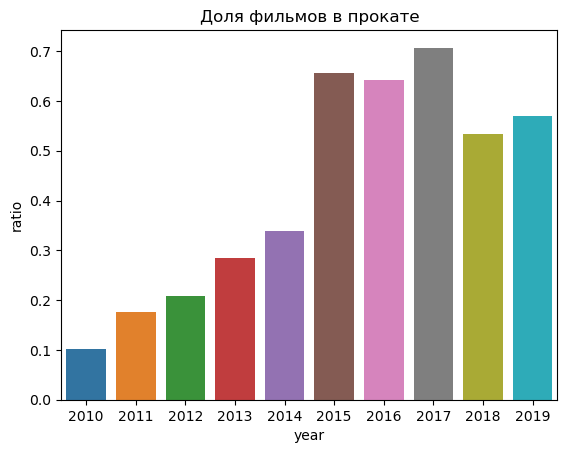

In [44]:
# Доля фильмов с указанной информацией о прокате в кинотеатрах по годам
data['is_show_cinema'] = data['box_office'].astype(bool)
cinema_by_year = data.groupby('year').agg({'is_show_cinema': ['count', 'sum']}).droplevel(0, axis=1).reset_index()
cinema_by_year['ratio']=cinema_by_year['sum'] / cinema_by_year['count']
display(cinema_by_year)
sns.barplot(x = cinema_by_year['year'] , y = cinema_by_year['ratio'])
plt.title('Доля фильмов в прокате')

,year,count,sum
0,2010,985,2428654.00
1,2011,622,14102765.00
2,2012,593,6955423.00
3,2013,630,29799706.20
4,2014,807,7444951859.20
5,2015,705,39497365196.40
6,2016,818,47866299741.91
7,2017,505,48563707217.51
8,2018,891,49668403134.32
9,2019,930,48425708779.59


Text(0.5, 1.0, 'Количество фильмов по годам')

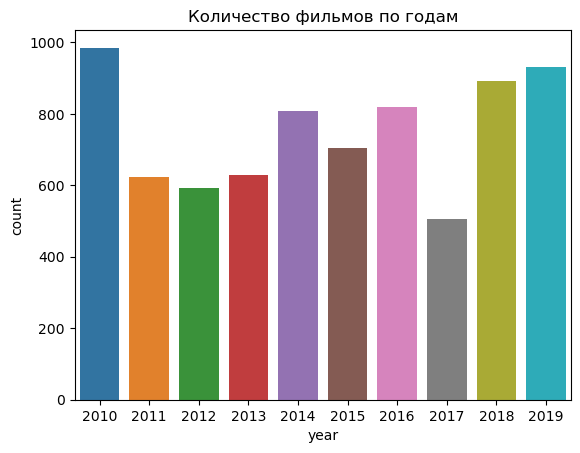

In [45]:
#кличество фильмов и сборы по годам.
film_by_year = data.groupby('year').agg({'box_office': ['count', 'sum']}).droplevel(0, axis=1).reset_index()
display(film_by_year)
sns.barplot(x = film_by_year['year'] , y = film_by_year['count'])
plt.title('Количество фильмов по годам')

- Изучим, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

<AxesSubplot:xlabel='year', ylabel='sum'>

Text(0.5, 1.0, 'Сборы по годам')

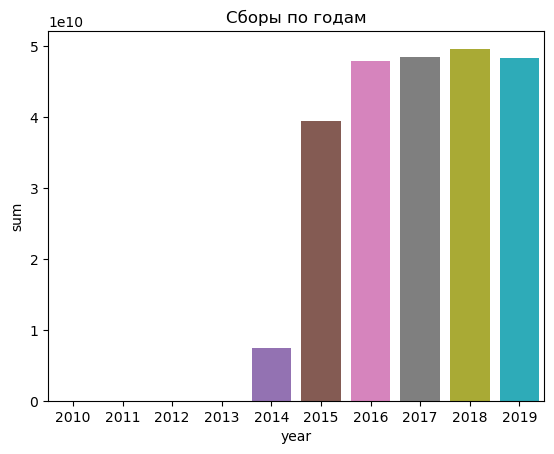

In [46]:
display(sns.barplot(x = film_by_year['year'] , y = film_by_year['sum']))
plt.title('Сборы по годам')

In [47]:
film_by_year.describe()

,year,count,sum
count,10.00,10.00,10.00
mean,2014.50,748.60,24151972247.71
std,3.03,160.85,24138278781.26
min,2010.00,505.00,2428654.00
25%,2012.25,624.00,18027000.30
50%,2014.50,756.00,23471158527.80
75%,2016.75,872.75,48285856520.17
max,2019.00,985.00,49668403134.32


###### Проанализировали фильмы по годам. В выборке содержится информация о сборах только для 41% фильмов. Причем с годами эта доля растет, если в 2010 году есть информация о сборах только для 10% картин, то в 2017 году - 70%. 
###### Общее распределение фильмов по годам не линейно. Максимальное количество картин вышло в 2010 году - 985. Минимальное в 2017году - 505.  Среднее и медианное значения практически совпадают, 748 и 756 штук в год соответственно. 
###### Сборы в целом повторяют график распределения доли фильмов в прокате. До 2015 года информации о сборах крайне мало менее 30%. Соответственно сборы так же на минимальном уровне - менее 1млрд. После 2015 информации о сборах гораздо больше и сумма вырастает до 49 млрд. руб.  Среднее значение сборов по всем годам   24 млрд. руб.  Медианное значение - 23  млрд. руб.

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

,mean,median
year,,
2010,2465.64,0.00
2011,22673.26,0.00
2012,11729.21,0.00
2013,47301.12,0.00
2014,9225466.99,0.00
2015,56024631.48,739938.00
2016,58516258.85,479832.50
2017,96165756.87,2522174.00
2018,55744560.20,289040.00


Text(0, 0.5, 'Рубли')

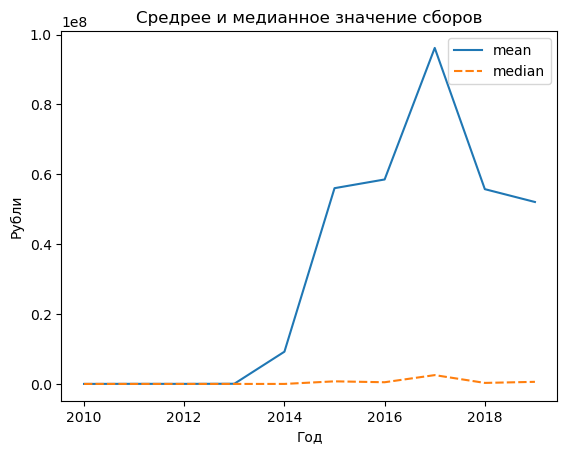

In [48]:
# Среднее и медиана по годам
sum_by_year = data.pivot_table(index = 'year', values = 'box_office', aggfunc =('mean', 'median'))
display(sum_by_year)
sns.lineplot(data = sum_by_year)
plt.title('Средрее и медианное значение сборов')
plt.xlabel('Год')
plt.ylabel('Рубли')

###### Из за недостаточности данных по сборам (Большое количество нулевых значений), видим что среднее о медианное значения сильно различаются. До 2014 года в расчет не берем так как данных по сборам менее 10%. А с 2014 акуратность данных возрастает до 70%.   Максимальное среднее значение приходится на 2017 год(более 90милн). Максимум медианы так же в 2017(2,5 млн). Как видим между средним и медианой колосальная разница. Виной тому неоднородность данных, присутстуют как нулевые значения так и крайне большие. 

#### Влияние возрастного ограничения

- Определим, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года?

In [49]:
# Сводная по возрастному ограничению
data_from_2015 = data.loc[data['year'] > 2014]
data_from_2015.groupby('age_restriction').agg({'box_office': ['count', 'sum', 'mean']}).droplevel(0, axis=1).reset_index()

,age_restriction,count,sum,mean
0,«0+» - для любой зрительской аудитории,317,809077425.97,2552294.72
1,«12+» - для детей старше 12 лет,789,60619446628.33,76830730.83
2,«16+» - для детей старше 16 лет,1172,76034733643.63,64876052.60
3,«18+» - запрещено для детей,1086,40759615572.12,37531874.38
4,«6+» - для детей старше 6 лет,485,55798610799.68,115048682.06


In [50]:
# Сводная по возрастному ограничению и годам
pivot_adge_year = data_from_2015.pivot_table(index = 'year', columns = 'age_restriction', values = 'box_office', aggfunc = 'sum')
pivot_adge_year

age_restriction,«0+» - для любой зрительской аудитории,«12+» - для детей старше 12 лет,«16+» - для детей старше 16 лет,«18+» - запрещено для детей,«6+» - для детей старше 6 лет
year,,,,,
2015,379054578.37,13616082008.91,11368120870.27,5432308367.44,8701799371.41
2016,150228848.67,12204446524.39,16664548541.74,6793929818.87,12053146008.24
2017,229598930.00,7851427660.67,18745042900.06,9651495581.02,12086142145.76
2018,32449002.11,14267291660.69,16503602346.96,8760085501.15,10104974623.41
2019,17746066.82,12680198773.67,12753418984.60,10121796303.64,12852548650.86


Text(0, 0.5, 'Рубли')

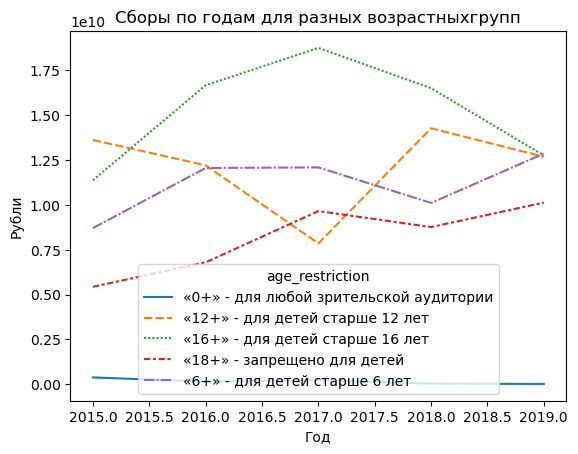

In [51]:
sns.lineplot(data = pivot_adge_year)
plt.title('Сборы по годам для разных возрастныхгрупп')
plt.xlabel('Год')
plt.ylabel('Рубли')

###### На графике и по сводным таблицм видно, что больше всего сборы у фильмов категории 16+, возможно это объясняется что таких фильмов больше всего. Так как если посмотреть на среднее значение, то у детских 6+ картин оно в два раза больше. 
###### Если смотреть расперделение по годам, то в лидерах так же категория 16+ (во всех периодах), а в аутсайдерах фильмы для любой зрительской аудитории 0+.

###  Исследуем фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

In [52]:
# Заведем столбец с господдержкой. Отфильтруем фильмы получившие господдержку
data['grant'] = data['refundable_support'] + data['nonrefundable_support']
data_granted = data.loc[data['grant'] > 0 ]
data_granted['paybak'] = data_granted['box_office'] - data_granted['grant']
data_granted

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,ratings,genres,box_office,year,director_first,genre_first,budget_ratio,is_show_cinema,grant,paybak
1281,пока еще жива,111005313,2013-10-11 12:00:00+00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00,...,8.10,"драма,мелодрама",365353.60,2013,А.Атанесян,драма,0.33,True,26500000.00,-26134646.40
1448,бесславные придурки,111003314,2014-03-28 12:00:00+00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00,...,NaN,NaN,28140.00,2014,А.Якимчук,NaN,0.70,True,26000000.00,-25971860.00
1498,невидимки,111004213,2013-09-10 12:00:00+00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00,...,5.30,"комедия,фантастика",19957031.50,2013,Р.Давлетьяров,комедия,0.61,True,107847945.00,-87890913.50
1524,берцы,111004314,2014-05-05 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00,...,4.20,драма,55917.50,2014,Е.Миндадзе (псевдоним Катя Шагалова),драма,0.69,True,28000000.00,-27944082.50
1792,братья ч,111004414,2014-04-23 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00,...,6.40,драма,232100.00,2014,М.Угаров,драма,0.62,True,25000000.00,-24767900.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,союз спасения,111022019,2019-12-26 12:00:00+00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,100000000.00,...,6.00,"история,биография,драма",717703185.53,2019,А.Кравчук,история,0.51,True,500000000.00,217703185.53
7466,иван царевич и серый волк 4,114005019,2019-12-20 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,100000000.00,...,6.70,"мультфильм,приключения,семейный",501069235.00,2019,Д.Шмидт,мультфильм,0.53,True,100000000.00,401069235.00
7474,вторжение,111022519,2019-12-23 12:00:00+00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,100000000.00,...,5.70,"фантастика,боевик",0.00,2019,Ф.Бондарчук,фантастика,0.53,False,500000000.00,-500000000.00
7476,я свободен,111023019,2019-12-26 12:00:00+00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0.00,...,5.90,драма,0.00,2019,И.Северов,драма,0.65,False,30000000.00,-30000000.00


In [53]:
# доля поддержки в бюджете
data_granted['grant'].sum()/data_granted['budget'].sum()

0.4629762405010332

In [54]:
data_granted['paybak'].describe()

count          332.00
mean      66002473.68
std      302569683.10
min     -500000000.00
25%      -29721261.88
50%      -20700217.88
75%       38651075.92
max     3013568690.79
Name: paybak, dtype: float64

In [55]:
# провальный фильм
data_granted.loc[data_granted['paybak'] == data_granted['paybak'].min()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,ratings,genres,box_office,year,director_first,genre_first,budget_ratio,is_show_cinema,grant,paybak
7474,вторжение,111022519,2019-12-23 12:00:00+00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,100000000.00,...,5.70,"фантастика,боевик",0.00,2019,Ф.Бондарчук,фантастика,0.53,False,500000000.00,-500000000.00


In [56]:
# успешный фильм
data_granted.loc[data_granted['paybak'] == data_granted['paybak'].max()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,ratings,genres,box_office,year,director_first,genre_first,budget_ratio,is_show_cinema,grant,paybak
7456,холоп,111021719,2019-12-19 12:00:00+00:00,Художественный,"ООО ""МЕМ-МЕДИА"" по заказу АО ""ВБД Груп""",Россия,К.Шипенко,"Э.Илоян, Д.Жалинский, В.Дусмухаметов, Т.Бадзие...",«12+» - для детей старше 12 лет,25000000.00,...,6.80,комедия,3073568690.79,2019,К.Шипенко,комедия,0.38,True,60000000.00,3013568690.79


In [57]:
# Рейтинг
data_granted['ratings'].describe()

count   314.00
mean      6.00
std       1.12
min       1.00
25%       5.30
50%       6.20
75%       6.70
max       8.50
Name: ratings, dtype: float64

In [58]:
data_granted.loc[data_granted['ratings'] == data_granted['ratings'].min()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,ratings,genres,box_office,year,director_first,genre_first,budget_ratio,is_show_cinema,grant,paybak
3515,взломать блогеров,111016616,2016-10-28 12:00:00+00:00,Художественный,"ООО ""ТаББаК""",Россия,М.Свешников,Т.Бекмамбетов,«6+» - для детей старше 6 лет,0.00,...,1.00,"комедия,мультфильм,фантастика",7323648.00,2016,М.Свешников,комедия,0.69,True,25000000.00,-17676352.00


In [59]:
data_granted.loc[data_granted['ratings'] == data_granted['ratings'].max()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,ratings,genres,box_office,year,director_first,genre_first,budget_ratio,is_show_cinema,grant,paybak
1870,а зори здесь тихие,111002915,2015-03-16 12:00:00+00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,Р.Давлетьяров,NaN,«12+» - для детей старше 12 лет,50000000.00,...,8.50,"драма,военный,история",249166767.70,2015,Р.Давлетьяров,драма,0.68,True,150000000.00,99166767.70
3627,большой,111017416,2016-11-22 12:00:00+00:00,Художественный,"ЗАО ""ПРОДЮСЕРСКАЯ КОМПАНИЯ ВАЛЕРИЯ ТОДОРОВСКОГО""",Россия,В.Тодоровский,"В.Тодоровский, А.Златопольский",«12+» - для детей старше 12 лет,10000000.00,...,8.50,"криминал,комедия,боевик",228578204.00,2016,В.Тодоровский,криминал,0.66,True,210000000.00,18578204.00


In [60]:
data_granted.pivot_table(index = 'director_first', values = 'paybak', aggfunc='sum').sort_values(by = 'paybak')

,paybak
director_first,
П.Лунгин,-203256726.79
Р.Давлетьяров,-160585012.56
И.Джендубаев,-139828551.50
В.Саков,-137634765.60
А.Котт,-125526964.77
...,...
О.Трофим,1360731797.89
Д.Дьяченко,2053898634.12
А.Сидоров,2091754004.52


###### Всего в выборке 332 фильма которые получали гос поддержку. Доля этой поддержки в общем бюджете картин 46%. Успешными, в финансовом плане, данные фильмы назвать сложно, так как медианное значение и первая квартиль сборов за вычетом поддержки оказалась отрицательной. 
###### Самый провальный в финансовом плане фильм - "Вторжение" Ф.Бондарчука. Самый успешный в финансовом плане фильм - "Холоп" К.Шипенко. 
###### Фильм, с господдержкой,  получивший меньше всего зрительских симпатий "Взломать блогеров" М.Свешникова, оценка 1.0
###### Фильмы, с господдержкой,  получивший больше всего зрительских симпатий "А зори здесь тихие" Р.Давлетьярова, оценка 8.5 и "Большой" В.Тодоровского оценка 8.5.
###### Самый провальный в прокате режисер - П.Лунгин (потратил гораздо больше, чем фильм заработал в прокате)
###### Самый успешный в прокате режисер - К.Шипенко (заработал гораздо больше, чем было господдержки)

#### Зависимости

<AxesSubplot:>

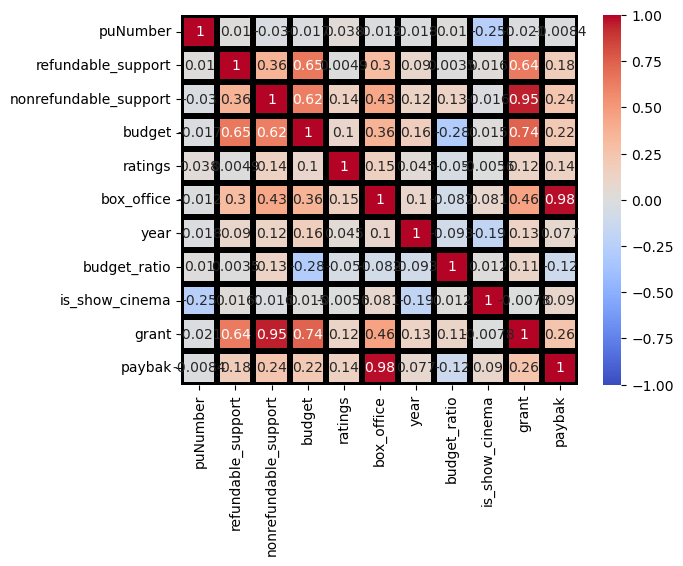

In [61]:
data_granted.corr()
sns.heatmap(
    data_granted.corr(), annot = True, vmin=-1, vmax=1,
    center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black',
)

##### Зависят ли сборы от суммы господдержки. 

0.45632186146154813

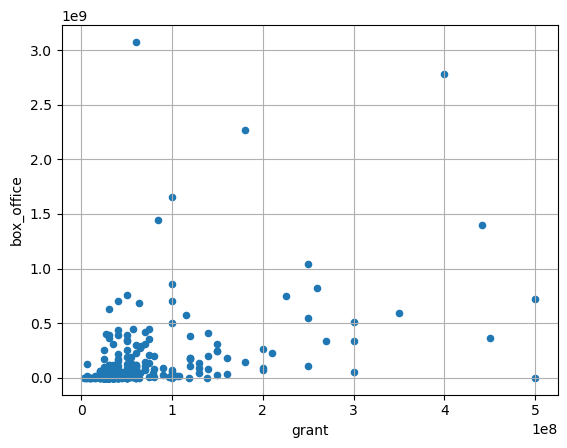

In [62]:
data_granted.plot(x= 'grant', y= 'box_office', kind= 'scatter', grid = True)
data_granted['grant'].corr(data_granted['box_office'])

###### Наблюдается не сильная линейная зависимость сборов от господдержки. Коэффициент кореляции Пирсона - 0.45. 

##### Зависит ли рейтинг от суммы господдержки.

0.11828746275619732

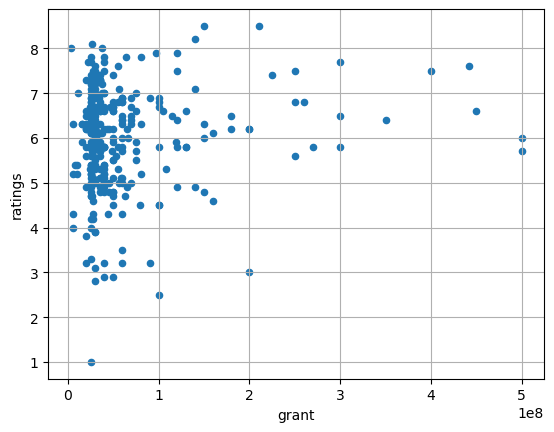

In [63]:
data_granted.plot(x= 'grant', y= 'ratings', kind= 'scatter', grid = True)
data_granted['grant'].corr(data_granted['ratings'])

###### Такой зависимости не наблюдается. Коэффициент кореляции Пирсона - 0.11

##### Зависит ли окупаемость от суммы господдержки

0.25536626569500404

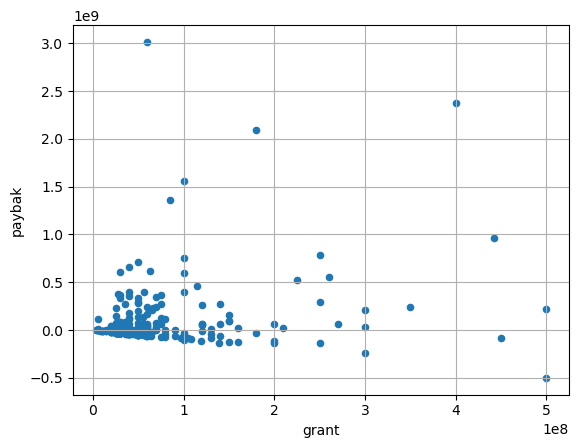

In [64]:
data_granted.plot(x= 'grant', y= 'paybak', kind= 'scatter', grid = True)
data_granted['grant'].corr(data_granted['paybak'])

###### Зависимости практически нет.  Коэффициент кореляции Пирсона - 0.25. Из графика видно крайне странная картина, чем боьше господдержка, тем меньше окупаемость картин.

##### Зависит ли сумма сборов от рейтинга

0.15184839872301328

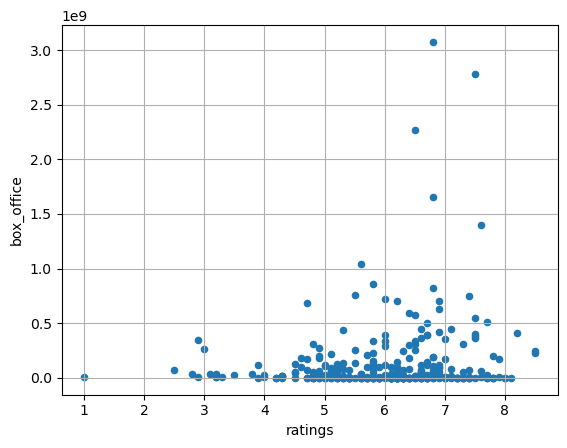

In [65]:
data_granted.plot(x= 'ratings', y= 'box_office', kind= 'scatter', grid = True)
data_granted['ratings'].corr(data_granted['box_office'])

###### Такой зависимости так же - нет. Коэффициент кореляции Пирсона - 0.15

### Общий вывод

###### В данной работе был проведен исследовательский анализ данных российского кинопроката с 2010 по 2019 год. Были проанализированы 7486 кинокартин. Проведена предобработка данных. Были удалены явные и не явные дубликаты. В данных содержится много пропусков. 
######  Были посчитаны дополнительные признаки. Доля господдержки в бюджете, Сумма господдержки, Окупаемость фильма. Доля господдержки в общем бюджете фильмов составила 46%. 
######  Был проведен исследовательский анализ данных.
###### Проанализировали фильмы по годам. В выборке содержится информация о сборах только для 41% фильмов.Общее распределение фильмов по годам не линейно. Максимальное количество картин вышло в 2010 году - 985. Минимальное в 2017году - 505. Среднее и медианное значения практически совпадают, 748 и 756 штук в год соответственно. Сборы в целом повторяют график распределения доли фильмов в прокате.Среднее значение сборов по всем годам 24 млрд. руб. Медианное значение - 23 млрд. руб
###### Проанализировали фильмы получившие господдержку. Всего таких фильмов в выборке 332. Успешными, в финансовом плане, данные фильмы назвать сложно, так как медианная окупаемость таких картин - отрицательная.
###### Посмотрели, как влияет возрастное ограничение на кассовые сборы. Больше всего сборы у фильмов категории 16+. Возможно это объясняется что таких фильмов больше всего. Так как если посмотреть на среднее значение, то у детских 6+ картин оно в два раза больше. Меньше всего кассовые сборы у фильмов для любой зрительской аудитории 0+.
###### Посмотрели другие зависимости. Наблюдается не сильная линейная зависимость сборов от господдержки. Остальные параметры слабо корелируются друг с другом. Возможно если данные были бы полнее кореляции удалось бы найти.

